## Tip Prediction Project

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import OneHotEncoder

### Load Data

In [3]:
# CSV-Dateien: direkt begrenzen
order_products = pd.read_csv('order_products.csv.zip', nrows=100000)
products = pd.read_csv('products.csv.zip', nrows=100000)
departments = pd.read_csv('departments.csv.zip', nrows=100000)
aisles = pd.read_csv('aisles.csv.zip', nrows=100000)
tips = pd.read_csv('tip25_trainingdata.csv.zip', nrows=100000)
tips.dropna(inplace=True) #Drop NaN-Values

# Parquet-Datei: erst laden, dann begrenzen
orders = pd.read_parquet('orders.parquet')
orders = orders.head(100000)

## Explore Data, Add Calendar Day & Create Main Dataframe

In [4]:
orders.head(5)

,order_id,user_id,order_date
0,1374495,3,2024-03-31 14:05:18
1,444309,3,2024-04-09 19:45:51
2,3002854,3,2024-04-30 16:25:20
3,2037211,3,2024-05-20 18:31:28
4,2710558,3,2024-06-01 17:52:27


In [5]:
# Get first and last date
first_date = orders['order_date'].min()
last_date = orders['order_date'].max()

print("First order date:", first_date)
print("Last order date:", last_date)

First order date: 2024-01-17 09:08:57
Last order date: 2025-04-19 16:06:23


In [6]:
# Create Calender
min_date = orders['order_date'].min().normalize()
max_date = orders['order_date'].max().normalize()

calendar = pd.DataFrame({
    'date': pd.date_range(start=min_date, end=max_date, freq='D')
})

calendar['weekday'] = calendar['date'].dt.day_name()
calendar['is_weekend'] = calendar['weekday'].isin(['Saturday', 'Sunday'])

# Preview
print(calendar.head())
print(calendar.tail())

        date    weekday  is_weekend
0 2024-01-17  Wednesday       False
1 2024-01-18   Thursday       False
2 2024-01-19     Friday       False
3 2024-01-20   Saturday        True
4 2024-01-21     Sunday        True
          date    weekday  is_weekend
454 2025-04-15    Tuesday       False
455 2025-04-16  Wednesday       False
456 2025-04-17   Thursday       False
457 2025-04-18     Friday       False
458 2025-04-19   Saturday        True


In [7]:
# Make sure 'order_date' is datetime
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Add weekday name
orders['weekday'] = orders['order_date'].dt.day_name()

# Flag weekends: Saturday or Sunday
orders['is_weekend'] = orders['weekday'].isin(['Saturday', 'Sunday']).astype(int)

orders.head(5)

,order_id,user_id,order_date,weekday,is_weekend
0,1374495,3,2024-03-31 14:05:18,Sunday,1
1,444309,3,2024-04-09 19:45:51,Tuesday,0
2,3002854,3,2024-04-30 16:25:20,Tuesday,0
3,2037211,3,2024-05-20 18:31:28,Monday,0
4,2710558,3,2024-06-01 17:52:27,Saturday,1


In [8]:
h = pd.merge(orders, tips, on='order_id', how='left') # Tipping behavior of this user
h['hour'] = h.order_date.dt.hour # Extract the hour of day into a new column

tip_by_hour = h[['hour','tip']].groupby(['hour']).mean() # Compute mean tipping rate by hour
tip_by_hour

,tip
hour,
0,0.641732
1,0.61794
2,0.541436
3,0.533333
4,0.526596
5,0.397626
6,0.444208
7,0.470899
8,0.461892


## -> Es gibt bestimmte Stunden, bei denen die Tipp-Rate höher ist

In [9]:
h[['hour','tip']].groupby(['hour']).count() #Total tips by hour

,tip
hour,
0,508
1,301
2,181
3,120
4,188
5,337
6,941
7,2835
8,5445


# Building Data Frame

In [10]:
#Add tip true or fales
orders_ext = pd.merge(orders, tips[['order_id', 'tip']], on='order_id', how='left')

orders_ext.head(5)

,order_id,user_id,order_date,weekday,is_weekend,tip
0,1374495,3,2024-03-31 14:05:18,Sunday,1,True
1,444309,3,2024-04-09 19:45:51,Tuesday,0,False
2,3002854,3,2024-04-30 16:25:20,Tuesday,0,False
3,2037211,3,2024-05-20 18:31:28,Monday,0,False
4,2710558,3,2024-06-01 17:52:27,Saturday,1,True


# Extract Previous Tip and Pre-Previous Tip

In [11]:
#Add previous order & pre-previous order
orders_ext['previous_tip'] = orders_ext['tip'].shift(1)
orders_ext['pre_previous_tip'] = orders_ext['tip'].shift(2)

orders_ext.head(5)

,order_id,user_id,order_date,weekday,is_weekend,tip,previous_tip,pre_previous_tip
0,1374495,3,2024-03-31 14:05:18,Sunday,1,True,None,None
1,444309,3,2024-04-09 19:45:51,Tuesday,0,False,True,None
2,3002854,3,2024-04-30 16:25:20,Tuesday,0,False,False,True
3,2037211,3,2024-05-20 18:31:28,Monday,0,False,False,False
4,2710558,3,2024-06-01 17:52:27,Saturday,1,True,False,False


# Test Data Frame Correlation

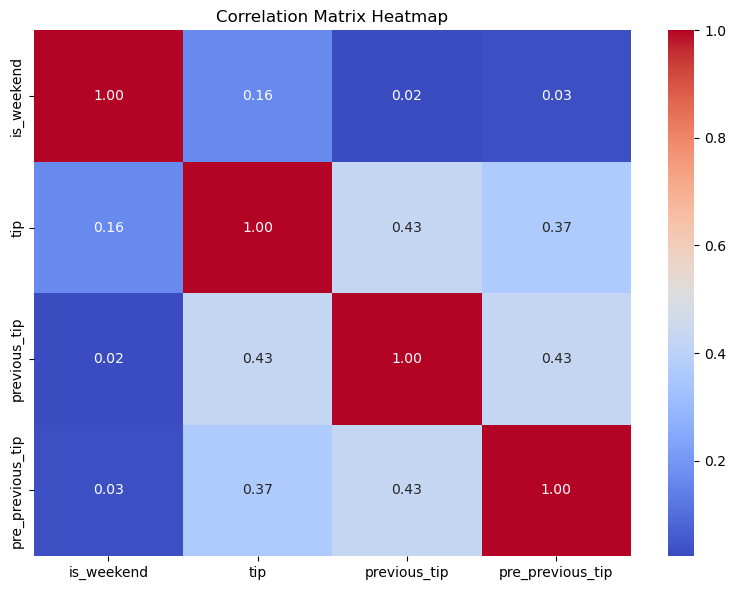

In [12]:
#Check Correlation Matrix

# Kopie und Vorbereitung
df = orders_ext.copy()

# Entferne Zeilen mit fehlenden Werten in wichtigen Spalten
df = df.dropna(subset=['tip', 'previous_tip', 'pre_previous_tip'])

# Konvertiere boolean Spalten zu int (0/1)
for col in ['tip', 'previous_tip', 'pre_previous_tip']:
    df[col] = df[col].astype(int)

# Korrelation (nur numerische Spalten)
corr_df = df.drop(columns=['order_id', 'user_id', 'order_date', 'weekday'])
correlation = corr_df.corr()

# Heatmap plotten
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

# Extending Data Frame (Extracting New Features: order_hour, tip_rate_hour)

In [13]:
#Add more features
orders_ext_v2 = orders_ext.copy()

#Extract column order hour
orders_ext_v2['order_hour'] = orders_ext_v2['order_date'].dt.hour

#Calculate tipping-rate per hour
tip_rate_by_hour = orders_ext_v2.groupby('order_hour')['tip'].mean().reset_index()
tip_rate_by_hour.rename(columns={'tip': 'tip_rate_hour'}, inplace=True)

#Map tipping rate per hour back to your dataframe
orders_ext_v2 = orders_ext_v2.merge(tip_rate_by_hour, on='order_hour', how='left')

orders_ext_v2.head(5)

,order_id,user_id,order_date,weekday,is_weekend,tip,previous_tip,pre_previous_tip,order_hour,tip_rate_hour
0,1374495,3,2024-03-31 14:05:18,Sunday,1,True,None,None,14,0.453003
1,444309,3,2024-04-09 19:45:51,Tuesday,0,False,True,None,19,0.598281
2,3002854,3,2024-04-30 16:25:20,Tuesday,0,False,False,True,16,0.448352
3,2037211,3,2024-05-20 18:31:28,Monday,0,False,False,False,18,0.442883
4,2710558,3,2024-06-01 17:52:27,Saturday,1,True,False,False,17,0.439693


# Test Data Frame Extention Correlation

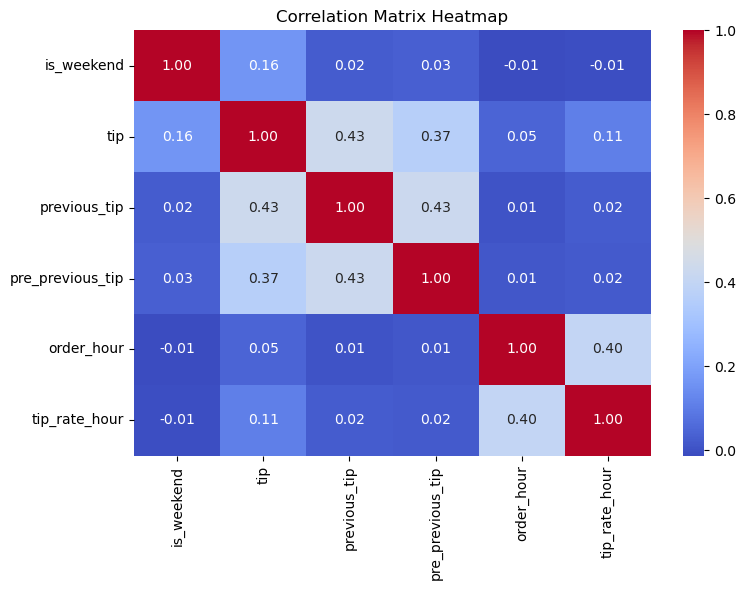

In [14]:
#Check Correlation Matrix

# Kopie und Vorbereitung
df_2 = orders_ext_v2.copy()

# Entferne Zeilen mit fehlenden Werten in wichtigen Spalten
df_2 = df_2.dropna(subset=['tip', 'previous_tip', 'pre_previous_tip'])

# Konvertiere boolean Spalten zu int (0/1)
for col in ['tip', 'previous_tip', 'pre_previous_tip']:
    df_2[col] = df_2[col].astype(int)

# Korrelation (nur numerische Spalten)
corr_df_2 = df_2.drop(columns=['order_id', 'user_id', 'order_date', 'weekday'])
correlation = corr_df_2.corr()

# Heatmap plotten
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

# Standard Random Forest

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Relevante Features + Zielspalte auswählen
features = ['is_weekend', 'previous_tip', 'pre_previous_tip', 'tip_rate_hour']
target = 'tip'

# 2. DataFrame auswählen und NaN-Zeilen in relevanten Spalten entfernen
df = orders_ext_v2[features + [target]].dropna()

# 3. Eingabematrix X und Zielvariable y
X = df[features]
y = df[target].astype(bool)  # explizit in bool konvertieren (alternativ .astype(int))

# 4. Split in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Modell initialisieren
clf = RandomForestClassifier(random_state=42)

# 6. Modell trainieren
clf.fit(X_train, y_train)

# 7. Modell auswerten
print(f"Train Accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {clf.score(X_test, y_test):.3f}")

# 7. Auswertung
print(f"Train Accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {clf.score(X_test, y_test):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))
print("\nClassification Report:")
print(classification_report(y_test, clf.predict(X_test)))

Train Accuracy: 0.728
Test Accuracy: 0.732
Train Accuracy: 0.728
Test Accuracy: 0.732

Confusion Matrix:
[[6893 2062]
 [2603 5854]]

Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.77      0.75      8955
        True       0.74      0.69      0.72      8457

    accuracy                           0.73     17412
   macro avg       0.73      0.73      0.73     17412
weighted avg       0.73      0.73      0.73     17412



# Random Forest + RandomSearch & Crossvalidation (Time-Series)

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint

# 1. Relevante Features + Zielspalte auswählen
features = ['is_weekend', 'previous_tip', 'pre_previous_tip', 'tip_rate_hour']
target = 'tip'

# 2. DataFrame auswählen und NaN-Zeilen in relevanten Spalten entfernen
df = orders_ext_v2[features + [target]].dropna()

# 3. Eingabematrix X und Zielvariable y
X = df[features]
y = df[target].astype(bool)

# 4. Zeitbasiertes Split: z.B. letzte 20% als Testdaten (chronologisch)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# 5. Random Forest ohne Parameter (Basis)
clf = RandomForestClassifier(random_state=42)

# 6. Parameterbereich für RandomizedSearch
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# 7. TimeSeriesSplit für zeitreihengerechte CV
tscv = TimeSeriesSplit(n_splits=3)

# 8. RandomizedSearch initialisieren
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=30,             # Anzahl der Kombinationen
    cv=tscv,               # Zeitreihen-CV verwenden
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 9. RandomizedSearch fitten (nur auf Trainingsdaten)
random_search.fit(X_train, y_train)

# 10. Bestes Modell ausgeben
best_clf = random_search.best_estimator_
print("Beste Parameter:", random_search.best_params_)

# 11. Evaluation auf Trainings- und Testdaten
print(f"Train Accuracy: {best_clf.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {best_clf.score(X_test, y_test):.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, best_clf.predict(X_test)))

print("\nClassification Report:")
print(classification_report(y_test, best_clf.predict(X_test)))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 144}
Train Accuracy: 0.730
Test Accuracy: 0.720

Confusion Matrix:
[[6771 2212]
 [2671 5758]]

Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.75      0.73      8983
        True       0.72      0.68      0.70      8429

    accuracy                           0.72     17412
   macro avg       0.72      0.72      0.72     17412
weighted avg       0.72      0.72      0.72     17412



## Kurze Notizen zum aktuellen Stand

**Weitere To Dos**:
- Restliche Features aus Feature Liste erstellen / testen 
- .predict_proba / Wahrscheinlichkeitsvorhersage erstellen -> zur Bewertung Log-Loss 
    - Prüfen ob Scores (z.B. Log-Loss-Score) als Wahrscheinlichkeit zu interpretieren sind 
- Weitere Modellklassen testen (z.B. Decision Tree mit ID.3 oder C.4, KNN, Log. Regr., Neural Network?)
- Dokumentation (Variablen, Ergebnisse)
    - (eventuell Improvement durch weitere Variablen dokumentieren - Variable prev_tip bereits 50-60% Wlk. zur korrekten Prognose)
- (später eventuell XGBoosting, SMOTE) 

***

**df = orders_ext_v2[features + [target]].dropna()** <br>
Können wir hier .dropna() einfach nutzen? Droppen wir hierdurch nicht einige Fälle, da durch previous_tip und pre_previous_tip einige Fälle rausfallen müssten, weil sie hier keine Werte haben können? Vor allem kleine Bestellungen fallen raus? Notwendig? Workaround?
- **Verteilung & Auswahl der Werte** genauer prüfen (welche Werte nutzen wir **wirklich**)
- möglicherweise **Expanding Window für Zeitreihe** nutzen (Time Series Crossvalidation) statt statischen Split? Oder größerer Sample-Satz für Feinheiten des Modells später ausreichend?
    - eventuell auch gut für Varianz und mögliches Overfitting?
- Generellen **Zeithorizont des Datensatzes hinterfragen** - macht es inhaltlich Sinn alle Daten zu benutzen oder hat sich das Verhalten der Kunden mit der Zeit geändert? Sinnvolle Prediction auf Gesamtdatensatz möglich/nötig? (**IID**)
<br>
<br>

***

**Sampling**: wir lesen von allem die ersten 10.000 Zeilen ein - aber sind das auch immmer dieselben Fälle? Da wir später joinen eventuell  schauen, welche Fälle wir letztlich wirklich haben. Eventuell inner join, falls keine Deckung, um Verhältnisse der Variablen nicht zu verzerren? --> Integritätsverletzungen?

***

**Bedingte Unabhängigkeit** zwischen Werten prüfen, um zu schauen, ob sie zum Modell beitragen? Bei hoher Korrelation von Features außerdem "eindeutige" Interpretierbarkeit erschwert. 

**Darstellung der Ergebnisse** möglicherweise später genauer erfassen, s. z.B. ROC-Kurve
- ROC-Kurve für ausgeglichene Klassen, Precision-Recall-Kurve für unausgewogene

***

Notizen
- Für Binärklassifizierung ist Fehlklassifikationsrate ähnlich zu Gini (keine Incentivierung der Unsicherheit zwischen Klassen nötig)


## Titel

In [18]:
# Erstellen weiterer Features
print(orders_ext_v2.columns)

Index(['order_id', 'user_id', 'order_date', 'weekday', 'is_weekend', 'tip',
       'previous_tip', 'pre_previous_tip', 'order_hour', 'tip_rate_hour'],
      dtype='object')
